In [1]:
from database_api import *
from Year import *
from Month import *
import matplotlib.pyplot as plt
from itertools import islice
import locale
import pandas as pd
locale.setlocale(locale.LC_ALL, '') 

'C/UTF-8/C/C/C/C'

In [2]:
def plot(years):
    fig = plt.figure(figsize=(16,9))
    for year in years:
        months = [Month(i,year.year_no) for i in range(1,13)]
        values = []
        try:
            for month in months:
                values.append(-round(month.tagStruct["Essen"]["Lebensmittel"],2))
        except AttributeError:
            print("Gotcha")
        plt.plot(values,label=year.year_no)
        plt.legend()
    plt.show()

In [33]:
computeBalances()
years = []
years.append(Year(2019))
years.append(Year(2020))
years.append(Year(2021))
years.append(Year(2022))
years.append(Year(2023))

In [28]:
months_years = []
for year in years:
    months = []
    for i in range(1,13):
        month = Month(i,year.year_no)
        if len(month.monthly_transacts) > 0:
            months.append(month)
    months_years.append(months)

In [4]:
for year in years:
    all_tags = {}
    biggest_tag = list(year.tagStruct.keys())[0]
    biggest_tag_value = list(list(year.tagStruct.values())[0].values())[0]
    for tag,subtags in year.tagStruct.items():
        for subtag, value in subtags.items():
            all_tags[(tag,subtag)] = value
    sorted_tags = {k: v for k, v in sorted(all_tags.items(), key=lambda item: item[1])}

In [23]:
def computePerMonthPerTagExpenses(months_years,tags,last_year=2022):
    expense_dict = {}
    for tag in tags:
        if type(tag) is tuple:
            tag_label = tag[0]+" - "+tag[1]
        else:
            tag_label = tag
        expense_dict[tag_label] = {}   
        for months in months_years:
            year_no = months[0].year_no
            if year_no <= last_year:
                expense_dict[tag_label][year_no] = {}
                for month in months:
                        if type(tag) is tuple: 
                            if tag[0] in month.tagStruct.keys():
                                if tag[1] in month.tagStruct[tag[0]].keys():
                                    expense_dict[tag_label][year_no][month.month_name] = -round(month.tagStruct[tag[0]][tag[1]],2)
                                else:
                                    expense_dict[tag_label][year_no][month.month_name] = 0
                            else:
                                expense_dict[tag_label][year_no][month.month_name] = 0
                        else:
                            if tag in month.tagStruct.keys():
                                expense_dict[tag_label][year_no][month.month_name] = -round(sum([month.tagStruct[tag][sub_tag] for sub_tag in month.tagStruct[tag].keys()],2))                            
                            else:
                                expense_dict[tag_label][year_no][month.month_name] = 0
    return expense_dict

In [8]:
def computePerMonthExpenses(months_years,tags,last_year=2022):
    expense_dict = {}
    for months in months_years:
        year_no = months[0].year_no
        if year_no <= last_year:
            expense_dict[year_no] = {}
            for month in months:
                expense_dict[year_no][month.month_name] = -month.total_spent
    return expense_dict

In [35]:
all_tags_yearly = {}
last_year = 2023
for y in years:
    if y.year_no == last_year:
       year = y  
for tag,subtags in year.tagStruct.items():
    total = 0
    for subtag, value in subtags.items():
        total -= value
    all_tags_yearly[tag] = round(total,2)
sorted_tags_yearly = {k: v for k, v in sorted(all_tags_yearly.items(), key=lambda item: item[1],reverse=True)}

In [36]:
tags = [tag for tag in sorted_tags_yearly]
tags = tags[:4]
#tags = ["Hardware","Digital","Wohnen"]
expense_dict = computePerMonthPerTagExpenses(months_years,tags,last_year=last_year)
all_tags_expense_dict = computePerMonthExpenses(months_years,tags,last_year=last_year)

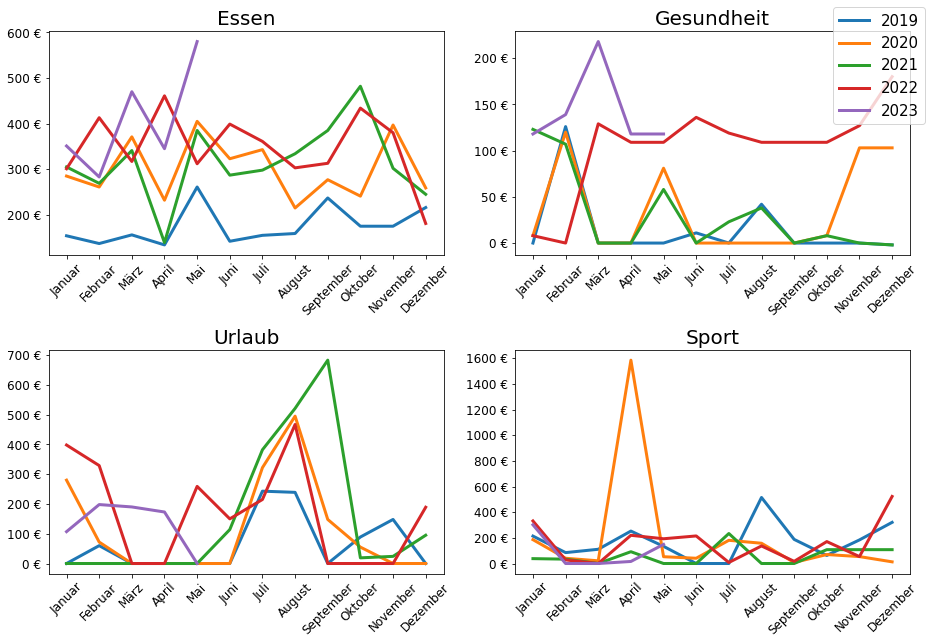

In [37]:
def plotPerTagExpenses(expense_dict,year,n_plots=4):
    fig,axs = plt.subplots(2,2,figsize=(13,9))
    for i,(tag,expenses) in enumerate(expense_dict.items()):
        ax = axs[i//2][i%2]
        ax.yaxis.set_major_formatter('{x:n} €')
        ax.set_title(tag, fontsize = 20)
        ax.tick_params(axis='x', which='major', labelsize=12,rotation=45)
        ax.tick_params(axis='y', which='major', labelsize=12)
        for year,months in expenses.items():
            values = []
            labels = []
            for month,value in months.items():
                values.append(value)
                labels.append(month)
            avg = round(sum(values)/len(values),2)
            ax.plot(labels, values, label = str(year),lw=3)
    fig.tight_layout()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, fontsize=15)
    fig.savefig("/Users/loris/src/Python/MoneyManager/Graphs/monthlyExpensesPerTag"+str(year)+".svg", bbox_inches="tight", dpi='figure')
    plt.show()
plotPerTagExpenses(expense_dict,last_year)  

## Comparison Bar Chart

In [15]:
expense_tag_per_year = {}
for year in years:
    expense_tag_per_year[year.year_no] = {}
    for tag,subtags in year.tagStruct.items():
        total = 0
        for subtag,value in subtags.items():
            total -= value
        expense_tag_per_year[year.year_no][tag] = round(total,2)

In [16]:
all_tags = {}
for tags in expense_tag_per_year.values():
    for tag,value in tags.items():
        if tag not in all_tags:
            all_tags[tag] = 0
        else:
            all_tags[tag] += value
all_tags = dict(sorted(all_tags.items(), key=lambda x:x[1],reverse=True))

In [17]:
expense_per_tag = {}
for tag in all_tags.keys():
    expense_per_tag[tag] = {}
    for year,yearly_tags in expense_tag_per_year.items():
        if tag in yearly_tags:
            expense_per_tag[tag][year] = yearly_tags[tag]
        else:
            expense_per_tag[tag][year] = 0
expense_per_tag = {k: v for k, v in sorted(expense_per_tag.items(), key=lambda item: max(item[1].values()),reverse=True)}

In [18]:
def plot_expense_per_tag_split(expense_per_tag,n_first = 3):
    big_boys = {}
    little_boys = {}
    for tag, expenses in expense_per_tag.items():
        if max(expenses.values()) < 1000:
            little_boys[tag] = expenses
        else:
            big_boys[tag] = expenses
            
    fig = plt.figure(figsize=(16,9))
    for tag, expenses in big_boys.items():
        values = []
        labels = []
        for year,value in expenses.items():
            values.append(value)
            labels.append(year)
        plt.bar(labels,values,label = tag)
    plt.legend()
    #fig.savefig("per_year_big_boys.svg", bbox_inches="tight", dpi=1000)

    fig = plt.figure(figsize=(16,9))
    for tag, expenses in islice(little_boys.items(), n_first):
        values = []
        labels = []
        for year,value in expenses.items():
            values.append(value)
            labels.append(year)
        plt.bar(labels,values,label = tag)
    
    plt.legend()
    #fig.savefig("per_year_little_boys.svg", bbox_inches="tight", dpi=1000)

    plt.show()
    
def plot_expense_per_tag(expense_per_tag):
    fig = plt.figure(figsize=(16,9))
    num_years = len(list(expense_per_tag.values())[0])
    bottom = num_years * [0]
    for tag, expenses in expense_per_tag.items():
        values = []
        labels = []
        #expenses = {k: v for k, v in sorted(expenses.items(), key=lambda item: item[1],reverse=True)}
        for year,value in expenses.items():
            values.append(value)
            labels.append(year)
        print(values,labels)
        
        plt.bar(labels,values,bottom = bottom, label = tag)
        bottom = [bottom[i]+values[i] for i in range(num_years)]
        #print(bottom)
    plt.legend()
    #fig.savefig("per_year_big_boys.svg", bbox_inches="tight", dpi=1000)

    plt.show()


In [19]:
expense_tag_per_year = {}
for tag in all_tags.keys():
    for year in years:
        expense_tag_per_year[year.year_no] = {}
        for tag in all_tags.keys():
            expense_tag_per_year[year.year_no][tag] = 0
        for tag,subtags in year.tagStruct.items():
            total = 0
            for subtag,value in subtags.items():
                total -= value
            expense_tag_per_year[year.year_no][tag] = round(total,2)


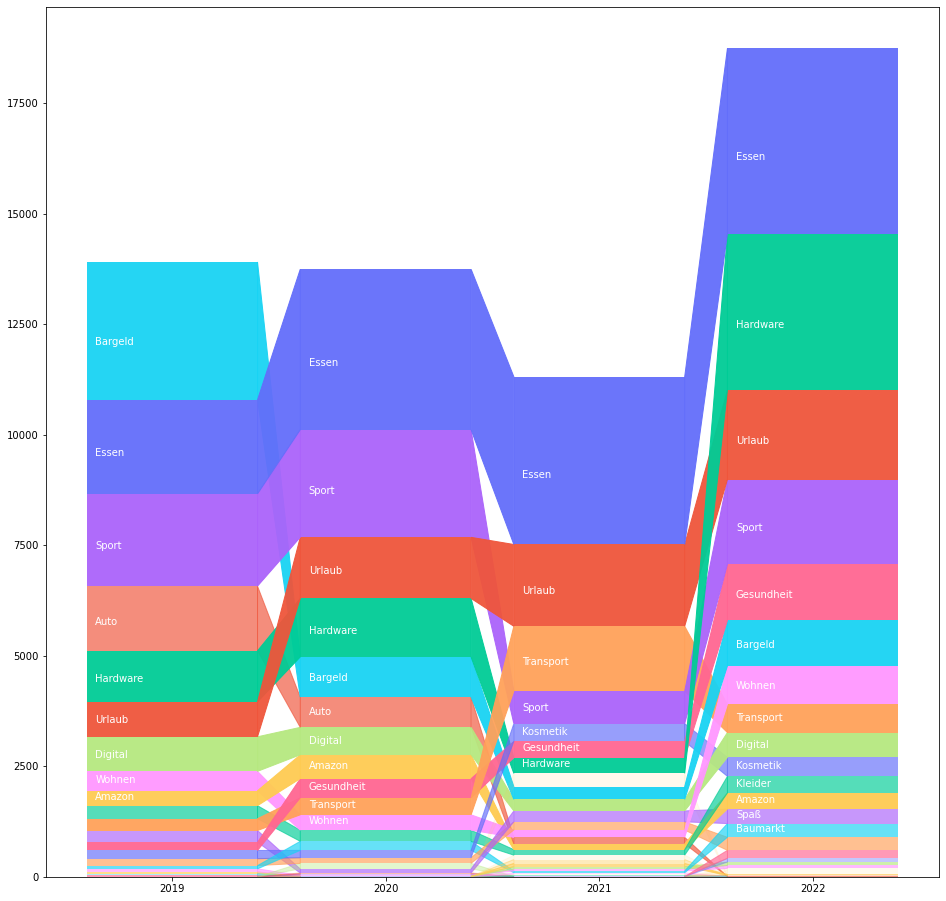

In [20]:
fig = plt.figure(figsize=(16,16))
ax = plt.gca()
base_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
colors = []
alphas = np.linspace(0.95,0.1,len(all_tags.keys()) // len(base_colors) + 1*(len(all_tags.keys()) % len(base_colors)>0) )
for i in range(0,len(all_tags.keys()) // len(base_colors)):
    for h in base_colors:
        colors.append([int(h[1:3], 16)/255.0,int(h[3:5],16)/255.0,int(h[5:7],16)/255.0,alphas[i]])
for j in range(0,len(all_tags.keys()) % len(base_colors)):
    colors.append([int(h[1:3], 16)/255.0,int(h[3:5],16)/255.0,int(h[5:7],16)/255.0,alphas[i+1]])

colormap = {tag: color for tag,color in zip(all_tags.keys(),colors)}
patches = {}
for year,tags in expense_tag_per_year.items():
    tags_sorted = {k: v for k, v in sorted(tags.items(), key=lambda item: item[1],reverse=False)}
    bottom = 0
    patches[year] = {}
    for tag,value in list(tags_sorted.items()):
        patch = ax.bar(str(year),value,bottom = bottom,label = tag,color=colormap[tag])
        child = patch.get_children()[0]
        patches[year][tag] = child
        (x1,y1) = child.get_xy()
        width1 = child.get_width()
        height1 = child.get_height()
        if value > 300:
            x_text = 0.05*width1 + x1
            y_text = 0.4*height1 + y1
            ax.text(x_text,y_text,tag,color="white")
        if year > 2019:
            prev_child = patches[year-1][tag]
            (x0,y0) = prev_child.get_xy()
            width0 = prev_child.get_width()
            height0 = prev_child.get_height()
            coord = [[x0+width0,y0], [x1,y1], [x1,y1+height1], [x0+width0,y0+height0]]
            coord.append(coord[0])
            xs, ys = zip(*coord)
            ax.fill(xs,ys,color=colormap[tag])
        bottom += value